# (19) $\log p(x)$ — importance weighted

**Motivation**: host = ```any```, device = ```cuda:3``` <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-vae/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-vae/figs')
tmp_dir = os.path.join(git_dir, 'jb-vae/tmp')

# GitHub
# sys.path.insert(0, os.path.join(git_dir, '_PoissonVAE'))
sys.path.insert(0, os.path.join(git_dir, '_IterativeVAE'))
from figures.fighelper import *
from vae.train_vae import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
from base.utils_model import load_quick
from figures.analysis import plot_convergence
from figures.imgs import plot_weights

device_idx = 3
device = f'cuda:{device_idx}'

print(f"device: {device}  ———  host: {os.uname().nodename}")

device: cuda:3  ———  host: mach

In [3]:
# model_name = 'poisson_MNIST_t-16_z-[256]_k-32_<jacob|conv>'
# fit_name = 'b200-ep400-lr(0.002)_beta(6:0x0.1)_temp(0.05:lin-0.5)_gr(150)_(2024_09_17,09:10)'

model_name = 'poisson_MNIST_t-16_z-[128]_k-32_<jacob|conv>'
fit_name = 'b200-ep400-lr(0.002)_beta(6:0x0.1)_temp(0.05:lin-0.5)_gr(150)_(2024_09_17,09:34)'

tr, meta = load_model(model_name=model_name, fit_name=fit_name, device=device, checkpoint=-1)
meta['checkpoint']

400

In [4]:
tr.model.cfg.clamp_u, tr.model.cfg.clamp_du

(8.0, 7.0)

In [5]:
print(tr.model.layer.n_exp)

tensor([16, 24, 31, 37, 42, 45, 48, 50, 52, 53, 54, 55, 56, 57, 58, 59],
       device='cuda:3', dtype=torch.int32)

In [6]:
x = next(iter(tr.dl_vld))[0]

In [7]:
nll_batch = tr.model.estimate_nll(
    x=x,
    seq_total=150_000,
    n_samples=100,
)

100%|████████████████████████████████| 150000/150000 [10:50:58<00:00,  3.84it/s]


In [10]:
save_obj(nll_batch, save_dir=tmp_dir, file_name='nll_batch', mode='npy')

[PROGRESS] 'nll_batch.npy' saved at
/home/hadi/Dropbox/git/jb-vae/tmp

In [11]:
nll = {k: v.mean(0) for k, v in nll_batch.items()}

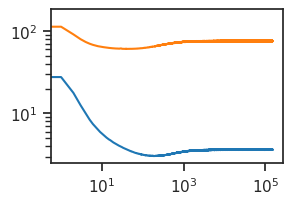

In [12]:
plt.loglog(nll['mse'])
plt.loglog(nll['bce']);

In [16]:
nll['mse'][:40000].mean(), nll['mse'].mean()

(3.618949, 3.6307182)

In [17]:
nll['bce']

array([150.92291 , 112.278206,  90.666115, ...,  75.24891 ,  75.60721 ,
        75.675735], dtype=float32)

In [18]:
cumulative_mean(nll['bce'])

array([150.9229126 , 131.60055542, 117.95573934, ...,  75.19874265,
        75.19874799,  75.19875333])

In [19]:
cumulative_mean(nll['mse'])

array([42.90213394, 35.22893524, 29.39859517, ...,  3.62904922,
        3.62904919,  3.62904917])

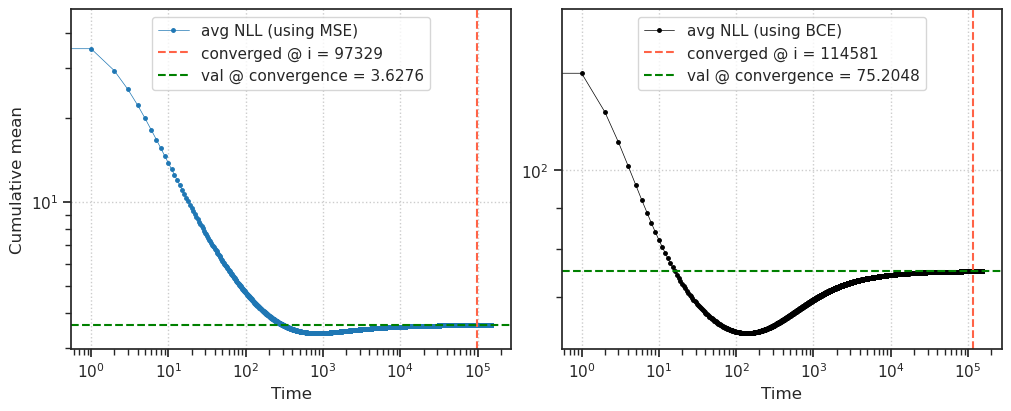

In [74]:
fig, axes = create_figure(1, 2, (10, 4))

for i, (k, v) in enumerate(nll.items()):
    ax = axes.flat[i]
    
    cum_mean = cumulative_mean(v)
    ax.loglog(
        cum_mean,
        lw=0.5,
        marker='.',
        markersize=5,
        color='C0' if i == 0 else 'k',
        label=f'avg NLL (using {k.upper()})',
    )
    
    convergence_i = find_cumulative_convergence(
        arr=v, window_size=1000, tol=3e-7 if i == 0 else 7e-6)
    ax.axvline(convergence_i, color='tomato', ls='--', label=f"converged @ i = {convergence_i}")
    ax.axhline(cum_mean[convergence_i], color='g', ls='--', label=f"val @ convergence = {cum_mean[convergence_i]:0.4f}")
    ax.set_xlabel('Time', fontsize=12)
axes[0].set_ylabel('Cumulative mean', fontsize=12)

add_legend(axes)
add_grid(axes)
plt.show()

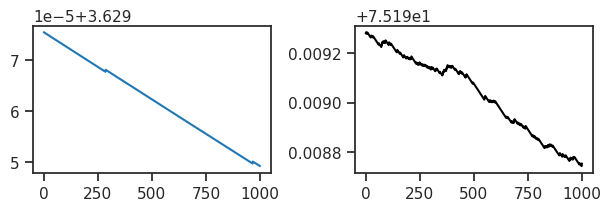

In [56]:
fig, axes = create_figure(1, 2)
axes[0].plot(cumulative_mean(nll['mse'])[-1000:]);
axes[1].plot(cumulative_mean(nll['bce'])[-1000:], color='k');

In [75]:
from base.distributions import Poisson, softclamp_upper_inv

In [13]:
log_prior_rate = softclamp_upper_inv(
    tr.model.layer.state,
    tr.model.cfg.clamp_u,
) - tr.model.layer.d_state

prior = Poisson(
    log_rate=log_prior_rate,
    temp=0.0,
    n_exp='infer',
    clamp=None,
)

In [14]:
prior.n_exp, tr.model.posterior.n_exp

(59, 59)

In [15]:
posterior = Poisson(
    log_rate=tr.model.layer.state,
    temp=0.0,
    n_exp='infer',
    clamp=None,
)

In [69]:
posterior.n_exp

58

In [70]:
tr.model.layer.state

tensor([[-3.0128, -3.2000, -1.4023,  ..., -0.1052, -0.8765,  0.9794],
        [-1.7562, -1.3943,  0.1285,  ...,  2.2352, -1.3350,  0.6332],
        [ 0.5005, -2.5535, -0.8493,  ...,  1.4792, -0.3112, -0.0112],
        ...,
        [-1.2951,  0.7156,  0.8598,  ..., -0.9239, -2.3847, -0.1379],
        [-1.7844,  1.0198, -1.5184,  ..., -1.7391,  1.4926, -1.5356],
        [-1.4421, -1.7429,  1.3929,  ..., -0.8176,  2.2151,  0.8939]],
       device='cuda:0')

In [71]:
torch.log(tr.model.posterior.rate)

tensor([[-3.0128, -3.2000, -1.4023,  ..., -0.1052, -0.8765,  0.9794],
        [-1.7562, -1.3943,  0.1285,  ...,  2.2352, -1.3350,  0.6332],
        [ 0.5005, -2.5535, -0.8493,  ...,  1.4792, -0.3112, -0.0112],
        ...,
        [-1.2951,  0.7156,  0.8598,  ..., -0.9239, -2.3847, -0.1379],
        [-1.7844,  1.0198, -1.5184,  ..., -1.7391,  1.4926, -1.5356],
        [-1.4421, -1.7429,  1.3929,  ..., -0.8176,  2.2151,  0.8939]],
       device='cuda:0')

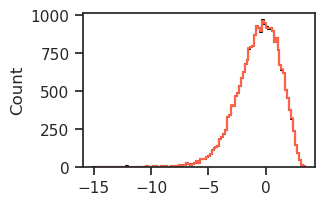

In [73]:
histplot(tonp(tr.model.layer.state.ravel()), color='k')
histplot(tonp(torch.log(tr.model.posterior.rate).ravel()), color='tomato');

In [74]:
max_r_1 = torch.exp(tr.model.layer.state).max()
max_r_1

tensor(29.1670, device='cuda:0')

In [75]:
max_r_2 = tr.model.posterior.rate.max()
max_r_2

tensor(29.1670, device='cuda:0')

In [76]:
from base.distributions import compute_n_exp

In [77]:
n_exp_1 = compute_n_exp(max_r_1.item(), 1e-6)
n_exp_2 = compute_n_exp(max_r_2.item(), 1e-6)

n_exp_1, n_exp_2

(58, 58)

In [18]:
torch.allclose(posterior.rate, tr.model.posterior.rate)

True

In [69]:
c = 5.0
x = torch.randn(100000) * 3

x_clamped = softclamp_upper(x, c)
x_unclamped = inverse_softclamp_upper(x_clamped, c)

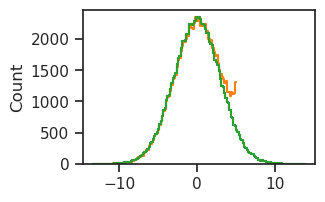

In [70]:
histplot(tonp(x.ravel()))
histplot(tonp(x_clamped.ravel()))
histplot(tonp(x_unclamped.ravel()));

<Axes: ylabel='Count'>

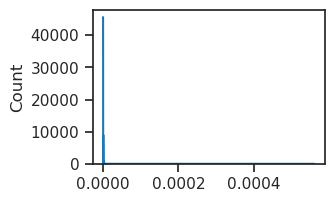

In [80]:
delta = tonp(torch.abs(x - x_unclamped))
histplot(delta)

In [81]:
delta.mean()

1.8537504e-07